# Spread & Volatility Feature Engineering
We will build features that quantify:
1. Forecast error
2. Imbalance cash‐out cost
3. Intraday vs imbalance price spreads
4. Rolling volatility of prices and spreads

All calculations are done on the merged dataset aligned by settlement‐period `datetime`.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

# Get absolute path for data directory
notebook_dir = Path().absolute()
DATA_DIR = notebook_dir.parent / "data" / "processed"
merged_path = DATA_DIR / "final_merged_clean.parquet"

df = pd.read_parquet(merged_path)
df = df.sort_values("datetime").reset_index(drop=True)

print(f"Loaded {merged_path} with shape {df.shape}")
print("\nAvailable columns:\n" + "\n".join(df.columns))

Loaded c:\Users\alexa\OneDrive\Desktop\GB-Power-Price-Diver-Spread-Radar\data\processed\final_merged_clean.parquet with shape (20327, 45)

Available columns:
datetime
SETTLEMENT_DATE_DEMAND
SETTLEMENT_PERIOD_DEMAND
ND_DEMAND
TSD_DEMAND
ENGLAND_WALES_DEMAND_DEMAND
EMBEDDED_WIND_GENERATION_DEMAND
EMBEDDED_WIND_CAPACITY_DEMAND
EMBEDDED_SOLAR_GENERATION_DEMAND
EMBEDDED_SOLAR_CAPACITY_DEMAND
NON_BM_STOR_DEMAND
PUMP_STORAGE_PUMPING_DEMAND
SCOTTISH_TRANSFER_DEMAND
IFA_FLOW_DEMAND
IFA2_FLOW_DEMAND
BRITNED_FLOW_DEMAND
MOYLE_FLOW_DEMAND
EAST_WEST_FLOW_DEMAND
NEMO_FLOW_DEMAND
NSL_FLOW_DEMAND
ELECLINK_FLOW_DEMAND
VIKING_FLOW_DEMAND
GREENLINK_FLOW_DEMAND
Settlement Date_INTRADAY
Settlement Period_INTRADAY
Market Index Data Provider Id_INTRADAY
Market Index Volume (MWh)_INTRADAY
Market Index Price (£/MWh)_INTRADAY
mip_price_INTRADAY
Settlement Date_IMBALANCE
Settlement Period_IMBALANCE
System Sell Price(GBP/MWh)_IMBALANCE
System Buy Price(GBP/MWh)_IMBALANCE
Net Imbalance Volume(MWh)_IMBALANCE
sbp_IM

In [2]:
# Remove other settlement columns except the DEMAND version
keep_cols = ['datetime', 'SETTLEMENT_DATE_DEMAND', 'SETTLEMENT_PERIOD_DEMAND'] + [c for c in df.columns if c not in [
    'Settlement Date_INTRADAY', 'Settlement Period_INTRADAY',
    'Settlement Date_IMBALANCE', 'Settlement Period_IMBALANCE',
    'settlementDate_FORECAST', 'settlementPeriod_FORECAST'
]]
df = df[keep_cols]

# Rename the DEMAND settlement columns
df = df.rename(columns={
    'SETTLEMENT_DATE_DEMAND': 'SETTLEMENT_DATE',
    'SETTLEMENT_PERIOD_DEMAND': 'SETTLEMENT_PERIOD'
})

print("Kept and renamed DEMAND settlement columns to standard names.")

Kept and renamed DEMAND settlement columns to standard names.


In [3]:
CONFIG = dict(
    # --- Forecast & actual demand ---
    forecast_ts_demand = "transmissionSystemDemand_FORECAST",   # ESO TSD forecast
    forecast_nat_demand = "nationalDemand_FORECAST",            # ESO ND forecast
    actual_ts_demand   = "TSD_DEMAND",                          # Actual TSD
    actual_nat_demand  = "ND_DEMAND",                           # Actual ND

    # --- Prices & volumes ---
    intraday_price     = "mip_price_INTRADAY",                  # Market Index Price (VWAP)
    sbp_price          = "sbp_IMBALANCE",                       # System Buy Price
    ssp_price          = "ssp_IMBALANCE",                       # System Sell Price
    niv_volume         = "niv_IMBALANCE",                       # Net Imbalance Volume

    # --- Rolling stats ---
    rolling_window     = 48    # 48 half-hours = 1 day
)

# Check only the column names, excluding the rolling_window parameter
missing_cols = [c for c in CONFIG.values() if not isinstance(c, int) and c not in df.columns]
if missing_cols:
    raise ValueError(f"Column(s) not found in loaded DataFrame: {missing_cols}")


In [4]:
def ensure_datetime_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Guarantee that the DataFrame has a 'datetime' column, not in the index.
    Handles cases where:
      • 'datetime' is the index and named
      • the index is unnamed but contains datetimes
      • duplicate 'datetime' columns exist
    Returns the adjusted DataFrame (creates a copy if needed).
    """
    # First handle duplicate datetime columns if they exist
    if df.columns.tolist().count("datetime") > 1:
        # Keep only the first datetime column
        first_datetime_idx = df.columns.tolist().index("datetime")
        df = df.iloc[:, [i for i, col in enumerate(df.columns) 
                        if col != "datetime" or i == first_datetime_idx]]
    
    # Now handle the datetime column location
    if "datetime" in df.columns:
        pass
    elif df.index.name == "datetime":
        df = df.reset_index()
    elif pd.api.types.is_datetime64_any_dtype(df.index):
        df = df.reset_index().rename(columns={"index": "datetime"})
    else:
        raise ValueError("DataFrame has no datetime information to plot.")

    # Ensure dtype is datetime64[ns, UTC] (if not already)
    if not pd.api.types.is_datetime64_any_dtype(df["datetime"]):
        df["datetime"] = pd.to_datetime(df["datetime"], utc=True, errors="coerce")
    
    return df

In [5]:
# Helper 2 – prettify X-axis (auto ticks)
def prettify_datetime_axis(ax, dates, max_ticks=12):
    """
    Set locator / formatter so ≤ max_ticks major labels are shown.
    Works for date spans from hours to years.
    """
    span_days = (dates.max() - dates.min()).days
    if span_days > 3 * 365:          # >3 years  → yearly ticks
        locator = mdates.YearLocator()
        fmt = mdates.DateFormatter('%Y')
    elif span_days > 365:            # 1-3 years → quarter ticks
        locator = mdates.MonthLocator(bymonth=[1,4,7,10])
        fmt = mdates.DateFormatter('%Y-%m')
    elif span_days > 120:            # 4-12 months
        locator = mdates.MonthLocator(interval=2)
        fmt = mdates.DateFormatter('%Y-%m')
    elif span_days > 60:             # 2-4 months
        locator = mdates.MonthLocator(interval=1)
        fmt = mdates.DateFormatter('%Y-%m')
    elif span_days > 7:              # 1-8 weeks
        locator = mdates.WeekdayLocator(byweekday=mdates.MO)
        fmt = mdates.DateFormatter('%Y-%m-%d')
    else:                            # <1 week
        locator = mdates.DayLocator()
        fmt = mdates.DateFormatter('%m-%d')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(fmt)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

### Forecast error features – quantifying model accuracy

We calculate:
- **Absolute forecast error** (MW) and **relative error** (%) for both Transmission System Demand (TSD) and National Demand (ND).

*Why?*  
- Absolute error shows how far off the forecast was (in MW).
- Relative error allows benchmarking and is more interpretable (especially across seasons).



In [6]:
df["err_TSD_MW"] = df[CONFIG["forecast_ts_demand"]] - df[CONFIG["actual_ts_demand"]]
df["err_TSD_%"]  = df["err_TSD_MW"] / df[CONFIG["actual_ts_demand"]]

df["err_ND_MW"]  = df[CONFIG["forecast_nat_demand"]] - df[CONFIG["actual_nat_demand"]]
df["err_ND_%"]   = df["err_ND_MW"] / df[CONFIG["actual_nat_demand"]]


#### Diagnostic: Forecast error (MW, TSD) – Outliers & Data Coverage


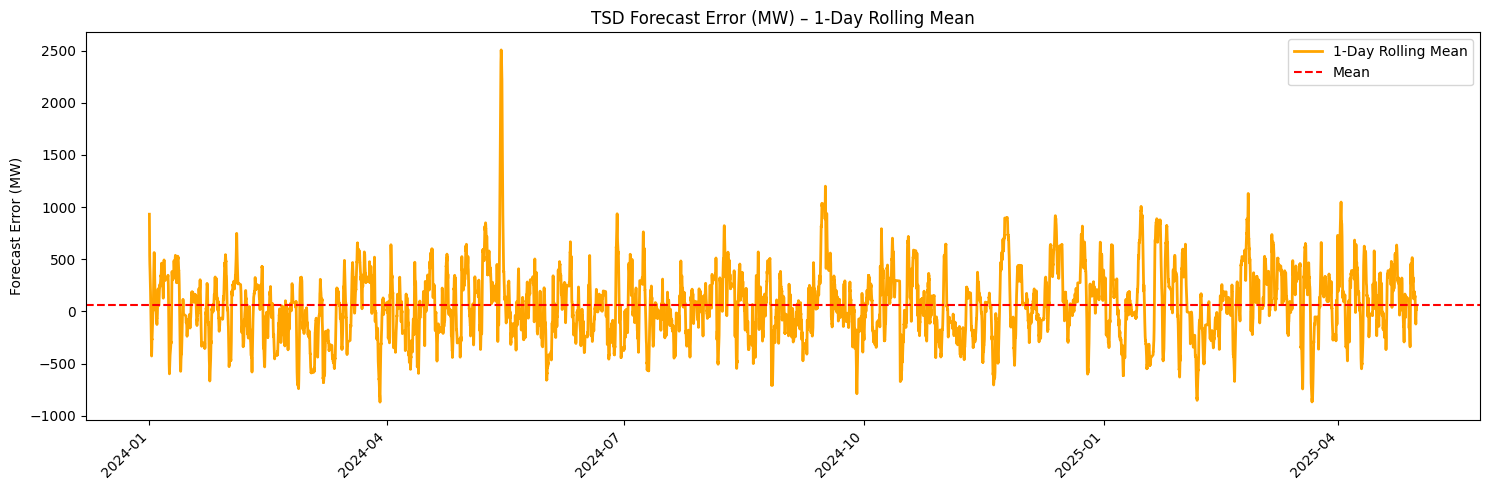

In [7]:
# --- 1. Rolling Average Trend over Full Period ---
import matplotlib.dates as mdates
df = ensure_datetime_column(df)
df['err_TSD_MW_rollmean'] = df['err_TSD_MW'].rolling(window=48, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df["datetime"], df["err_TSD_MW_rollmean"], '-', color='orange', lw=2, label='1-Day Rolling Mean')
ax.axhline(df["err_TSD_MW"].mean(), color='red', linestyle='--', label='Mean')
ax.set_title("TSD Forecast Error (MW) – 1-Day Rolling Mean")
ax.set_ylabel("Forecast Error (MW)")
ax.legend()
prettify_datetime_axis(ax, df["datetime"])
plt.tight_layout()
plt.show()


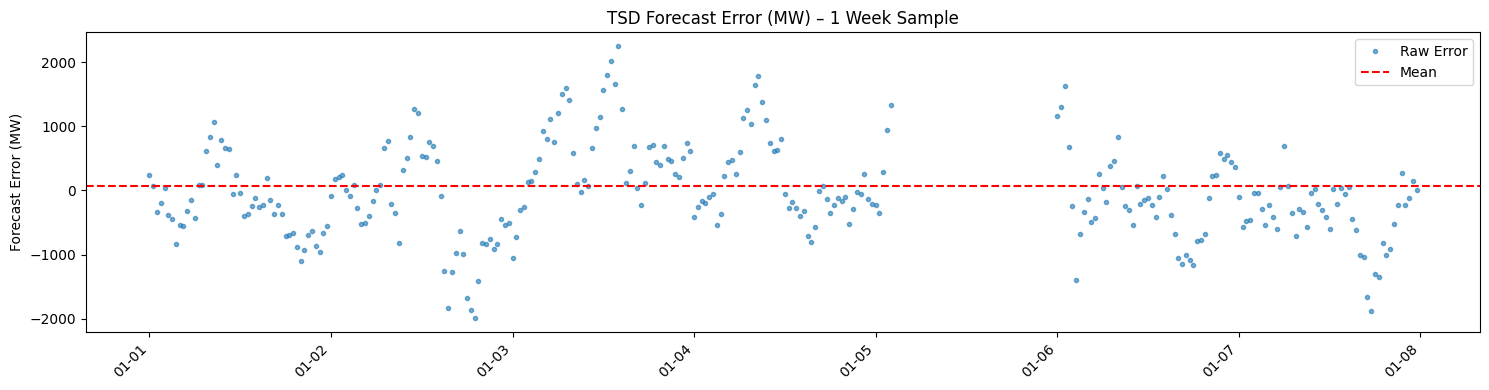

In [8]:
# --- 2. Raw Half-Hourly Error (Zoomed to One Week) ---
# Pick a week with normal or interesting error behavior:
week = (df["datetime"] >= "2025-01-01") & (df["datetime"] < "2025-01-08")

fig, ax = plt.subplots(figsize=(15,4))
ax.plot(df.loc[week, "datetime"], df.loc[week, "err_TSD_MW"], '.', alpha=0.6, label="Raw Error")
ax.axhline(df["err_TSD_MW"].mean(), color='red', linestyle='--', label='Mean')
ax.set_title("TSD Forecast Error (MW) – 1 Week Sample")
ax.set_ylabel("Forecast Error (MW)")
ax.legend()
prettify_datetime_axis(ax, df.loc[week, "datetime"])
plt.tight_layout()
plt.show()


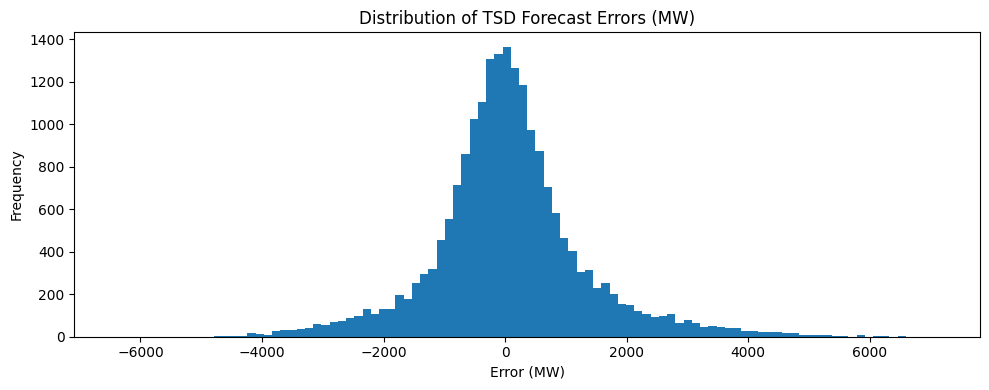

In [9]:
# 3. Histogram
df["err_TSD_MW"].plot.hist(bins=100, figsize=(10,4))
plt.title("Distribution of TSD Forecast Errors (MW)")
plt.xlabel("Error (MW)")
plt.tight_layout()
plt.show()

#### Diagnostic: Forecast error (ND, %) – Outliers & Data Coverage

Visualize time series and distribution for National Demand forecast error (%).


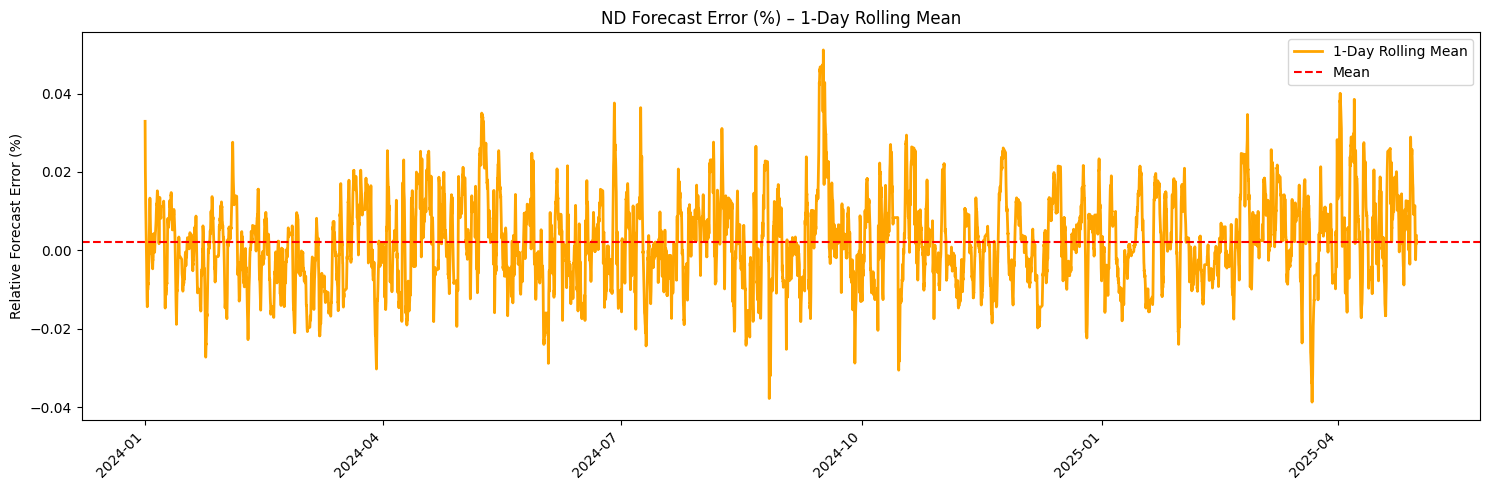

In [10]:
df = ensure_datetime_column(df)
df['err_ND_%_rollmean'] = df['err_ND_%'].rolling(window=48, min_periods=1).mean()

# 1. Rolling Mean (full period)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df["datetime"], df["err_ND_%_rollmean"], '-', color='orange', lw=2, label='1-Day Rolling Mean')
ax.axhline(df["err_ND_%"].mean(), color='red', ls='--', label='Mean')
ax.set_title("ND Forecast Error (%) – 1-Day Rolling Mean")
ax.set_ylabel("Relative Forecast Error (%)")
ax.legend()
prettify_datetime_axis(ax, df["datetime"])
plt.tight_layout()
plt.show()

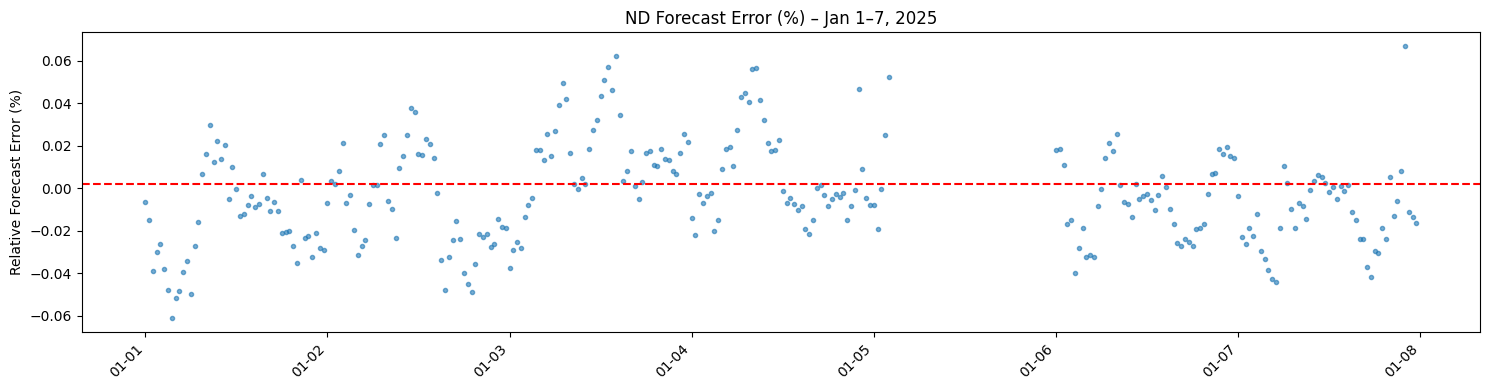

In [11]:
# 2. Raw (zoomed to 1 week)
week = (df["datetime"] >= "2025-01-01") & (df["datetime"] < "2025-01-08")
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(df.loc[week, "datetime"], df.loc[week, "err_ND_%"], '.', alpha=0.6)
ax.axhline(df["err_ND_%"].mean(), color='red', ls='--')
ax.set_title("ND Forecast Error (%) – Jan 1–7, 2025")
ax.set_ylabel("Relative Forecast Error (%)")
prettify_datetime_axis(ax, df.loc[week, "datetime"])
plt.tight_layout()
plt.show()

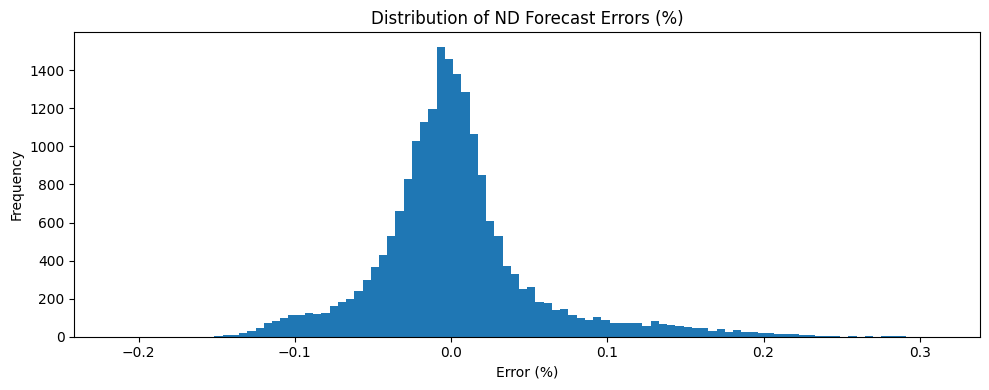

In [12]:
# 3. Histogram
df["err_ND_%"].plot.hist(bins=100, figsize=(10,4))
plt.title("Distribution of ND Forecast Errors (%)")
plt.xlabel("Error (%)")
plt.tight_layout()
plt.show()

### 5. Imbalance cash-out cost

*Imbalance cash-out cost* is the real-world financial outcome of being out of balance:
- If the system is **short** (NIV > 0), you pay System Buy Price (SBP) for your imbalance.
- If the system is **long** (NIV < 0), you get System Sell Price (SSP) for your excess.

*Why?*  
This feature estimates the GBP impact of operational or forecasting errors—a core market risk metric.


In [13]:
sbp = CONFIG["sbp_price"]
ssp = CONFIG["ssp_price"]
niv = CONFIG["niv_volume"]

df["cashout_cost_GBP"] = np.where(
    df[niv] > 0,
    df[niv] * df[sbp],
    df[niv] * df[ssp]
)

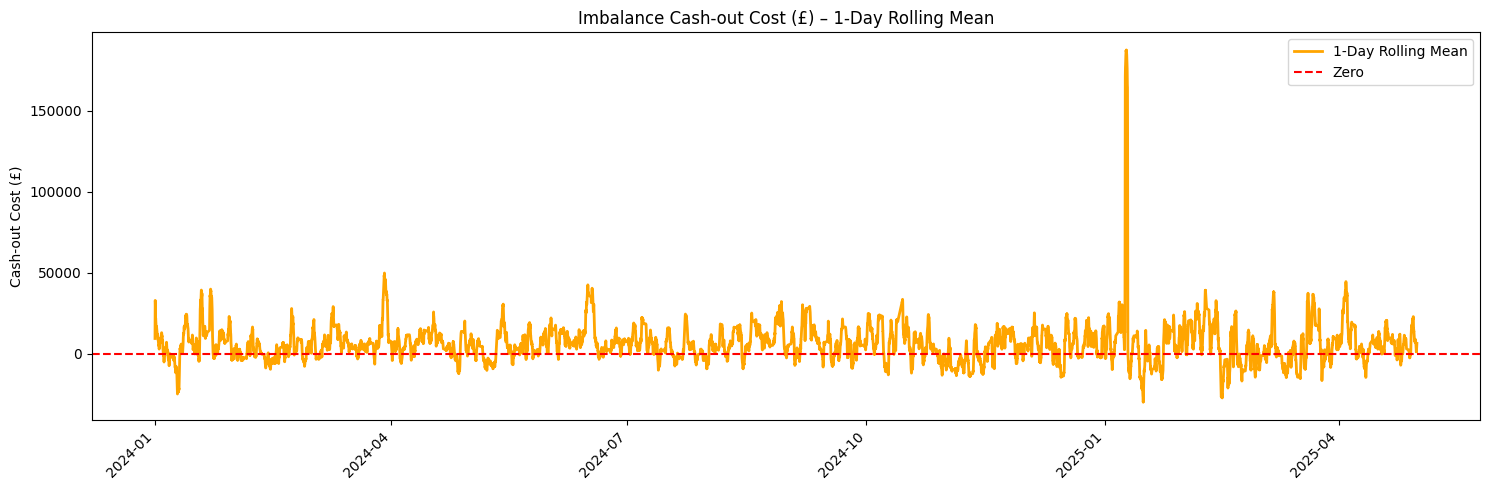

In [14]:
df['cashout_cost_GBP_rollmean'] = df['cashout_cost_GBP'].rolling(window=CONFIG['rolling_window'], min_periods=1).mean()

# 1. Rolling Mean (full period)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df["datetime"], df["cashout_cost_GBP_rollmean"], '-', color='orange', lw=2, label='1-Day Rolling Mean')
ax.axhline(y=0, color='red', ls='--', label='Zero')
ax.set_title("Imbalance Cash-out Cost (£) – 1-Day Rolling Mean")
ax.set_ylabel("Cash-out Cost (£)")
ax.legend()
prettify_datetime_axis(ax, df["datetime"])
plt.tight_layout()
plt.show()

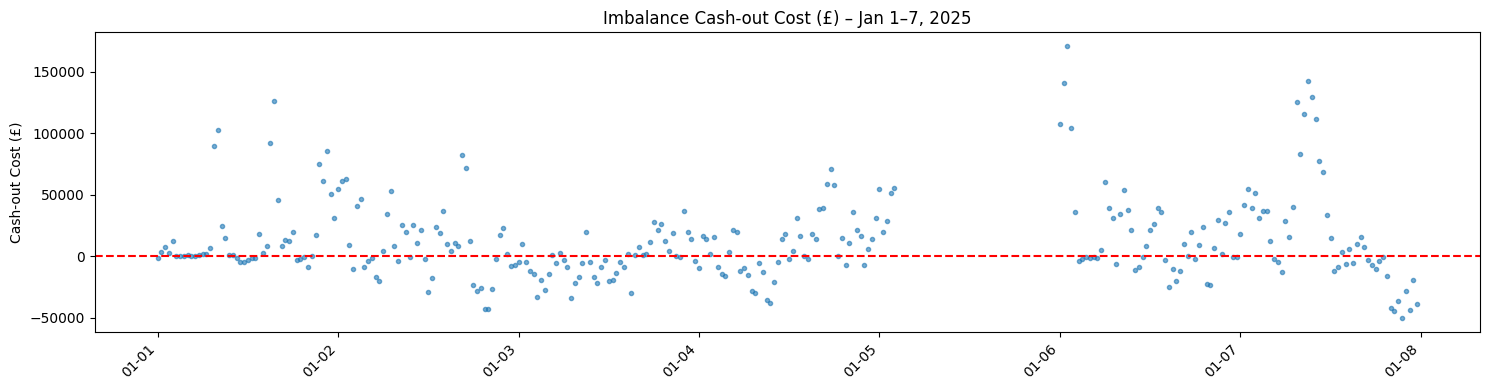

In [15]:
# 2. Raw (zoomed to 1 week)
week = (df["datetime"] >= "2025-01-01") & (df["datetime"] < "2025-01-08")
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(df.loc[week, "datetime"], df.loc[week, "cashout_cost_GBP"], '.', alpha=0.6)
ax.axhline(y=0, color='red', ls='--', label='Zero') 
ax.set_title("Imbalance Cash-out Cost (£) – Jan 1–7, 2025")
ax.set_ylabel("Cash-out Cost (£)")
prettify_datetime_axis(ax, df.loc[week, "datetime"])
plt.tight_layout()
plt.show()

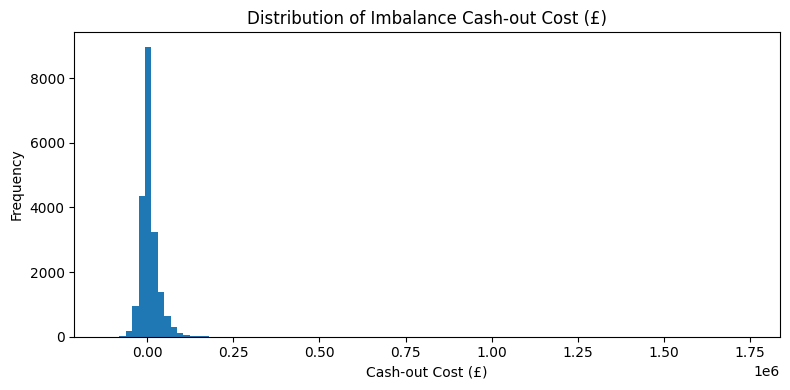

In [16]:
# 3. Histogram
df["cashout_cost_GBP"].plot.hist(bins=100, figsize=(8,4))
plt.title("Distribution of Imbalance Cash-out Cost (£)")
plt.xlabel("Cash-out Cost (£)")
plt.tight_layout()
plt.show()

### 6. Intraday vs Imbalance price spreads

These spreads measure the price signal the market sends about balancing flexibility:
- **SBP vs MIP**: How much higher the imbalance price was (vs intraday market) when short.
- **MIP vs SSP**: How much higher (or lower) the intraday price was compared to the sell price for surplus.

*Why?*  
Traders use these spreads to benchmark trading strategies and to evaluate flexibility rewards/penalties.


In [17]:
mip = CONFIG["intraday_price"]

df["spread_SBP_vs_MIP"] = df[sbp] - df[mip]
df["spread_MIP_vs_SSP"] = df[mip] - df[ssp]


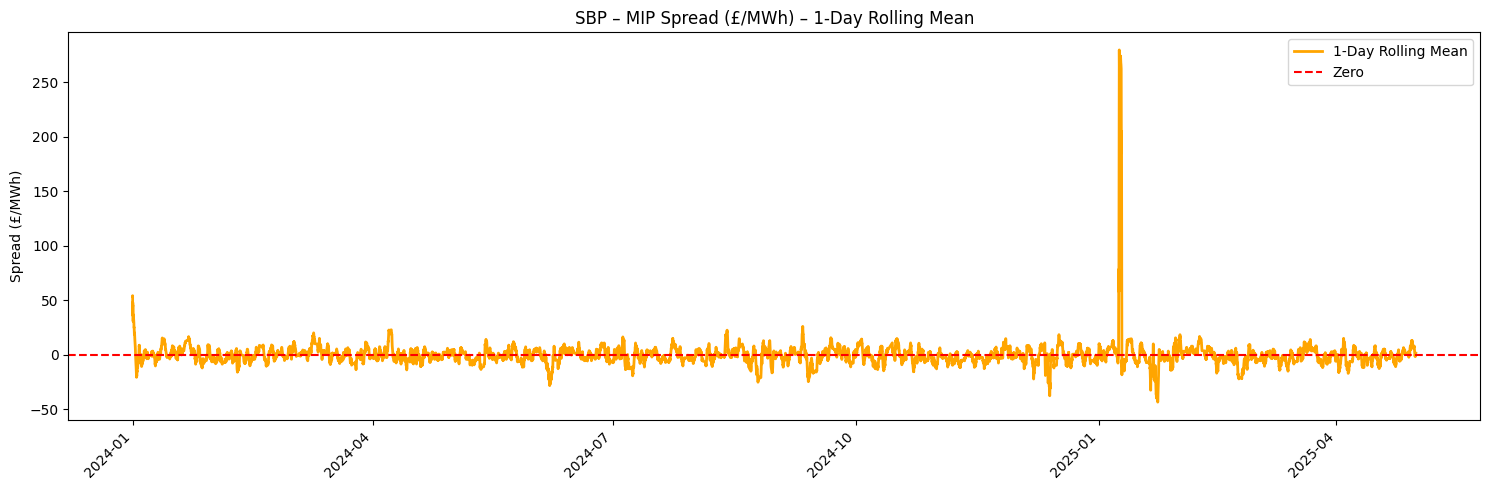

In [18]:
df = ensure_datetime_column(df)
df['spread_SBP_vs_MIP_rollmean'] = df['spread_SBP_vs_MIP'].rolling(window=48, min_periods=1).mean()

# 1. Rolling Mean (full period)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df["datetime"], df["spread_SBP_vs_MIP_rollmean"], '-', color='orange', lw=2, label='1-Day Rolling Mean')
ax.axhline(y=0, color='red', ls='--', label='Zero')
ax.set_title("SBP – MIP Spread (£/MWh) – 1-Day Rolling Mean")
ax.set_ylabel("Spread (£/MWh)")
ax.legend()
prettify_datetime_axis(ax, df["datetime"])
plt.tight_layout()
plt.show()

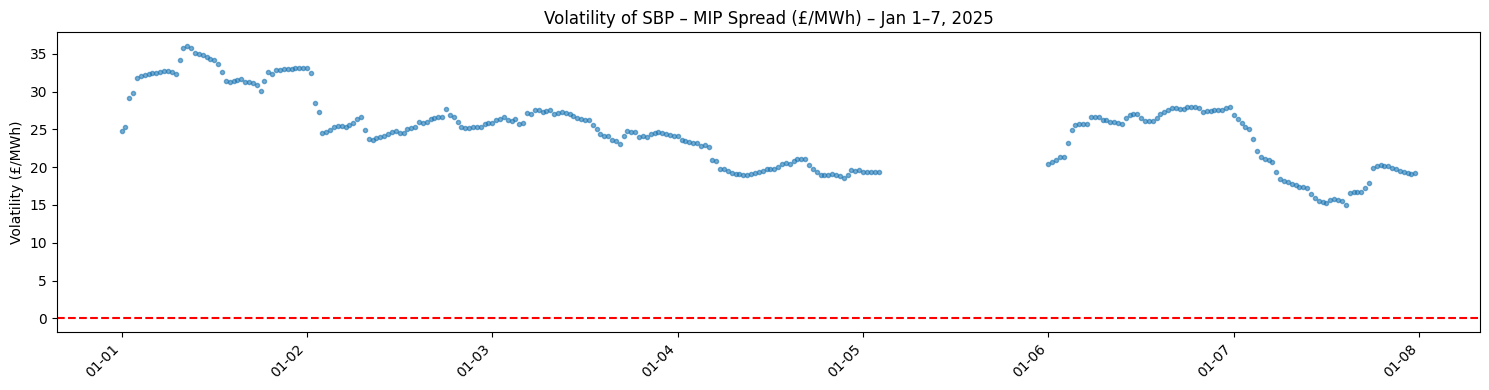

In [19]:
# Ensure rolling volatility column exists
if "vol_spread_SBP_vs_MIP" not in df.columns:
    if "spread_SBP_vs_MIP" not in df.columns:
        raise KeyError("Missing spread_SBP_vs_MIP column needed for volatility calculation.")
    df["vol_spread_SBP_vs_MIP"] = df["spread_SBP_vs_MIP"].rolling(window=48, min_periods=1).std()

# 2. Raw (zoomed to 1 week)
week = (df["datetime"] >= "2025-01-01") & (df["datetime"] < "2025-01-08")
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(df.loc[week, "datetime"], df.loc[week, "vol_spread_SBP_vs_MIP"], '.', alpha=0.6)
ax.axhline(y=0, color='red', ls='--', label='Zero') 
ax.set_title("Volatility of SBP – MIP Spread (£/MWh) – Jan 1–7, 2025")
ax.set_ylabel("Volatility (£/MWh)")
prettify_datetime_axis(ax, df.loc[week, "datetime"])
plt.tight_layout()
plt.show()


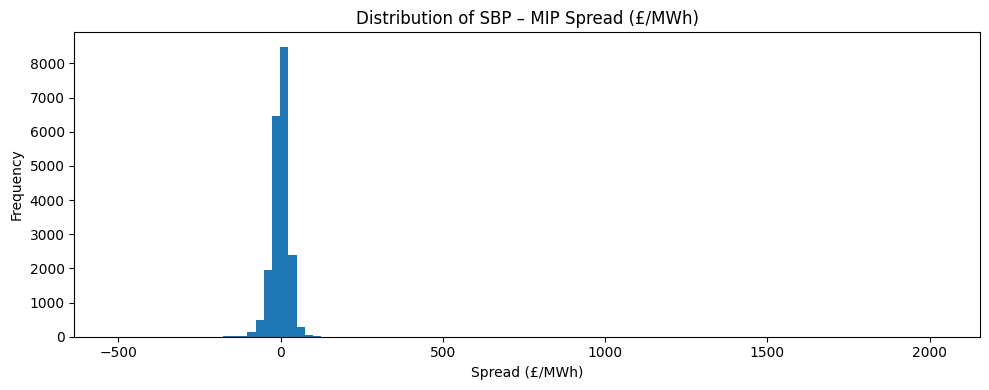

In [20]:
# 3. Histogram
df["spread_SBP_vs_MIP"].plot.hist(bins=100, figsize=(10,4))
plt.title("Distribution of SBP – MIP Spread (£/MWh)")
plt.xlabel("Spread (£/MWh)")
plt.tight_layout()
plt.show()

### 7. Rolling volatility of errors and spreads

*Volatility* is calculated as the rolling standard deviation (over 1 day by default) of:
- Forecast error (%)
- Price spreads

*Why?*  
- High volatility indicates uncertain/unstable market conditions.
- Useful for model regime selection, trading risk sizing, and alarm thresholds.


In [21]:
w = CONFIG["rolling_window"]
vol_cols = ["err_TSD_%", "spread_SBP_vs_MIP", "spread_MIP_vs_SSP"]

for col in vol_cols:
    df[f"vol_{col}"] = df[col].rolling(window=w, min_periods=int(w*0.8)).std()


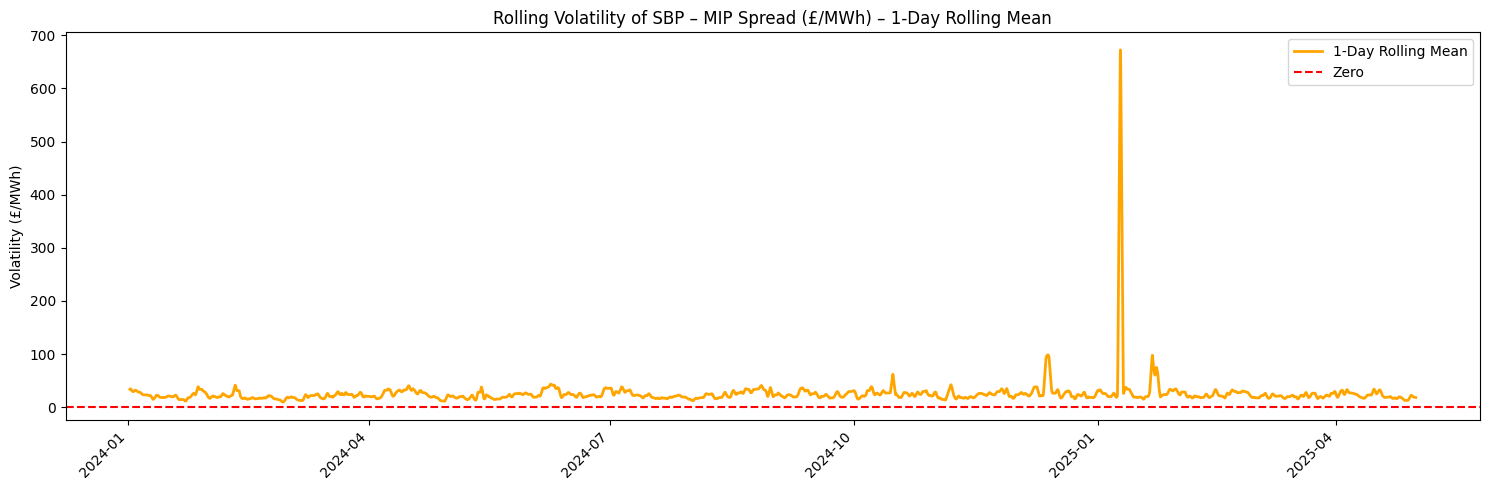

In [22]:
df = ensure_datetime_column(df)
df['vol_spread_SBP_vs_MIP_rollmean'] = df['vol_spread_SBP_vs_MIP'].rolling(window=48, min_periods=1).mean()

# 1. Rolling Mean (full period)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df["datetime"], df["vol_spread_SBP_vs_MIP_rollmean"], '-', color='orange', lw=2, label='1-Day Rolling Mean')
ax.axhline(y=0, color='red', ls='--', label='Zero') 
ax.set_title("Rolling Volatility of SBP – MIP Spread (£/MWh) – 1-Day Rolling Mean")
ax.set_ylabel("Volatility (£/MWh)")
ax.legend()
prettify_datetime_axis(ax, df["datetime"])
plt.tight_layout()
plt.show()


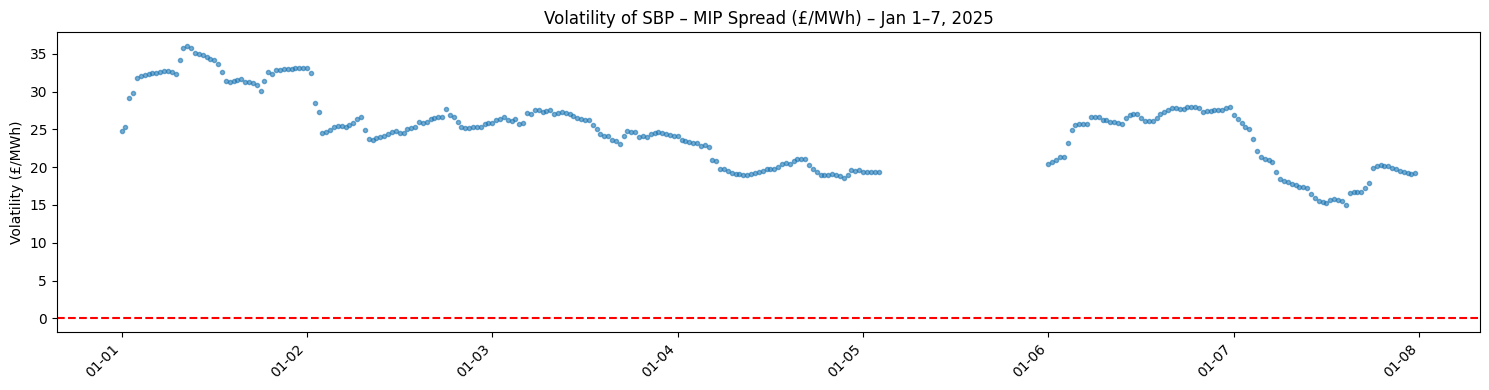

In [23]:
# 2. Raw (zoomed to 1 week)
week = (df["datetime"] >= "2025-01-01") & (df["datetime"] < "2025-01-08")
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(df.loc[week, "datetime"], df.loc[week, "vol_spread_SBP_vs_MIP"], '.', alpha=0.6)
ax.axhline(y=0, color='red', ls='--', label='Zero') 
ax.set_title("Volatility of SBP – MIP Spread (£/MWh) – Jan 1–7, 2025")
ax.set_ylabel("Volatility (£/MWh)")
prettify_datetime_axis(ax, df.loc[week, "datetime"])
plt.tight_layout()
plt.show()

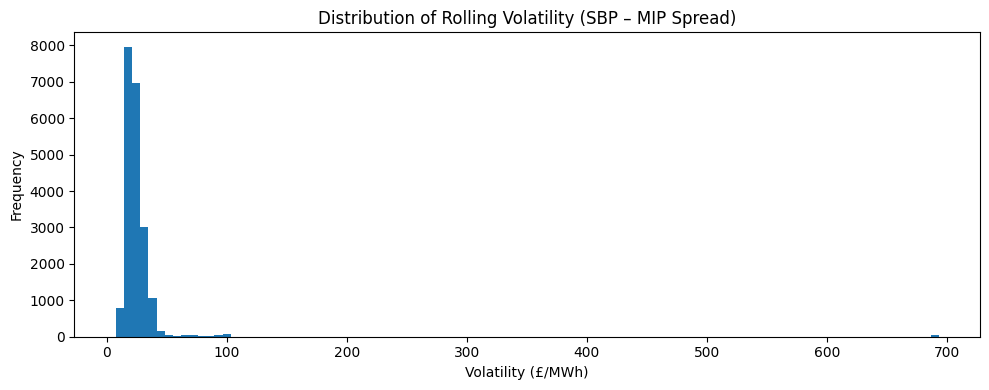

In [24]:
# 3. Histogram
df["vol_spread_SBP_vs_MIP"].plot.hist(bins=100, figsize=(10,4))
plt.title("Distribution of Rolling Volatility (SBP – MIP Spread)")
plt.xlabel("Volatility (£/MWh)")
plt.tight_layout()
plt.show()

Final Statistics

In [25]:
feature_cols = [c for c in df.columns if c.startswith(("err_","spread_","vol_","cashout_cost"))]
print("Feature columns:", feature_cols)
display(df[["datetime"] + feature_cols].head(3))
print(df[feature_cols].describe().T)


Feature columns: ['err_TSD_MW', 'err_TSD_%', 'err_ND_MW', 'err_ND_%', 'err_TSD_MW_rollmean', 'err_ND_%_rollmean', 'cashout_cost_GBP', 'cashout_cost_GBP_rollmean', 'spread_SBP_vs_MIP', 'spread_MIP_vs_SSP', 'spread_SBP_vs_MIP_rollmean', 'vol_spread_SBP_vs_MIP', 'vol_err_TSD_%', 'vol_spread_MIP_vs_SSP', 'vol_spread_SBP_vs_MIP_rollmean']


,datetime,err_TSD_MW,err_TSD_%,err_ND_MW,err_ND_%,err_TSD_MW_rollmean,err_ND_%_rollmean,cashout_cost_GBP,cashout_cost_GBP_rollmean,spread_SBP_vs_MIP,spread_MIP_vs_SSP,spread_SBP_vs_MIP_rollmean,vol_spread_SBP_vs_MIP,vol_err_TSD_%,vol_spread_MIP_vs_SSP,vol_spread_SBP_vs_MIP_rollmean
0,2024-01-01 00:00:00+00:00,932.0,0.039717,717.0,0.032916,932.000000,0.032916,9301.68000,9301.68000,53.49,-53.49,53.490000,NaN,NaN,NaN,NaN
1,2024-01-01 00:30:00+00:00,684.0,0.028378,579.0,0.025709,808.000000,0.029312,19753.50000,14527.59000,54.83,-54.83,54.160000,NaN,NaN,NaN,NaN
2,2024-01-01 01:00:00+00:00,587.0,0.023713,469.0,0.021132,734.333333,0.026586,26317.81437,18457.66479,0.00,0.00,36.106667,NaN,NaN,NaN,NaN


                                  count         mean           std  \
err_TSD_MW                      20327.0    61.069759   1252.499217   
err_TSD_%                       20327.0     0.003495      0.047369   
err_ND_MW                       20327.0    20.530083   1250.056593   
err_ND_%                        20327.0     0.002027      0.052148   
err_TSD_MW_rollmean             20327.0    61.730300    326.818055   
err_ND_%_rollmean               20327.0     0.002048      0.011071   
cashout_cost_GBP                20327.0  6263.842760  33904.253278   
cashout_cost_GBP_rollmean       20327.0  6276.828437  12959.724382   
spread_SBP_vs_MIP               20327.0    -0.089372     44.401390   
spread_MIP_vs_SSP               20327.0     0.089372     44.401390   
spread_SBP_vs_MIP_rollmean      20327.0    -0.051289     14.293326   
vol_spread_SBP_vs_MIP           20290.0    25.728501     33.862005   
vol_err_TSD_%                   20290.0     0.039853      0.023692   
vol_spread_MIP_vs_SS

In [29]:
nan_counts = df[feature_cols].isna().sum()
print("NaN counts per feature column:")
print(nan_counts[nan_counts > 0])

# Identify the time period(s) where NaNs appear for each feature column
for col in nan_counts[nan_counts > 0].index:
    nan_idx = df[df[col].isna()].index
    if not nan_idx.empty:
        first_nan_time = df.loc[nan_idx[0], "datetime"]
        last_nan_time = df.loc[nan_idx[-1], "datetime"]
        print(f"{col}: NaNs from {first_nan_time} to {last_nan_time} (total {len(nan_idx)})")

NaN counts per feature column:
vol_spread_SBP_vs_MIP             37
vol_err_TSD_%                     37
vol_spread_MIP_vs_SSP             37
vol_spread_SBP_vs_MIP_rollmean    37
dtype: int64
vol_spread_SBP_vs_MIP: NaNs from 2024-01-01 00:00:00+00:00 to 2024-01-01 18:00:00+00:00 (total 37)
vol_err_TSD_%: NaNs from 2024-01-01 00:00:00+00:00 to 2024-01-01 18:00:00+00:00 (total 37)
vol_spread_MIP_vs_SSP: NaNs from 2024-01-01 00:00:00+00:00 to 2024-01-01 18:00:00+00:00 (total 37)
vol_spread_SBP_vs_MIP_rollmean: NaNs from 2024-01-01 00:00:00+00:00 to 2024-01-01 18:00:00+00:00 (total 37)


In [30]:
# Remove all rows with NaNs in any of the feature columns
df = df.dropna(subset=feature_cols)
print(f"DataFrame shape after NaN removal: {df.shape}")

DataFrame shape after NaN removal: (20290, 54)


In [31]:
# Remove duplicate columns by name, keeping the first occurrence
df = df.loc[:, ~df.columns.duplicated()]

output_path = DATA_DIR / "final_merged_with_features.parquet"
df.to_parquet(output_path, index=False)
print(f"Saved DataFrame with features to {output_path}")

Saved DataFrame with features to c:\Users\alexa\OneDrive\Desktop\GB-Power-Price-Diver-Spread-Radar\data\processed\final_merged_with_features.parquet
